## Yield Spread model

This notebook contains a model that predicts new yield spreads based on reference data. The model was trained using data collected between January 1, 2023, and March 1, 2023, and was tested on data from March 2023. Since there is no last trade to estimate new_ys for new issues, the model predicts yield spread.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import time

import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns

from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from datetime import datetime
import matplotlib.pyplot as plt
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMRegressor
import lightgbm

from IPython.display import display, HTML
import os


from ficc.data.process_data import process_data
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, IDENTIFIERS, PURPOSE_CLASS_DICT
from ficc.utils.gcp_storage_functions import upload_data, download_data
from ficc.utils.auxiliary_variables import RELATED_TRADE_BINARY_FEATURES, RELATED_TRADE_NON_CAT_FEATURES, RELATED_TRADE_CATEGORICAL_FEATURES

Initializing pandarallel with 16.0 cores
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Setting the environment variables

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="ahmad_creds.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

Initializing BigQuery client

In [3]:
bq_client = bigquery.Client()

Initializing GCP storage client

In [4]:
storage_client = storage.Client()

Removing some features as they will be not available for new issues

In [5]:
PREDICTORS.remove('trade_history')
PREDICTORS.remove('issue_price')
NON_CAT_FEATURES.remove('issue_price')

PREDICTORS.remove('last_yield_spread')
NON_CAT_FEATURES.remove('last_yield_spread')

PREDICTORS.remove('last_seconds_ago')
NON_CAT_FEATURES.remove('last_seconds_ago')

    

Declaring hyper-parameters

In [6]:
TRAIN_TEST_SPLIT = 0.85
LEARNING_RATE = 0.0001
BATCH_SIZE = 1000
NUM_EPOCHS = 100
DROPOUT = 0.01

Checking if the treasury spreads and target attention features are present in PREDICTORS 

In [7]:
if 'ficc_treasury_spread' not in PREDICTORS:
    PREDICTORS.append('ficc_treasury_spread')
    NON_CAT_FEATURES.append('ficc_treasury_spread')

#### Data Preparation
We grab the data from a GCP bucket. The data is prepared using the ficc python package. More insight on how the data is prepared can be found [here](https://github.com/Ficc-ai/ficc/blob/ahmad_ml/ml_models/sequence_predictors/data_prep/data_preparation.ipynb)

In [8]:
%%time
import gcsfs
fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
with fs.open('automated_training/processed_data.pkl') as f:
    data = pd.read_pickle(f)

CPU times: user 1min 44s, sys: 35.3 s, total: 2min 19s
Wall time: 5min 39s


#### Date range for data

In [9]:
data.trade_date.max()

Timestamp('2023-05-05 00:00:00')

In [10]:
data.trade_date.min()

Timestamp('2022-05-02 00:00:00')

In [11]:
len(data)

9948865

For the purpose of plotting, not used in training

In [12]:
data.purpose_sub_class.fillna(0, inplace=True)

Creating new ys label

In [13]:
data['new_ys'] = data['yield'] - data['new_ficc_ycl']

Selecting a subset of features for training. PREDICTORS are the features that we are going to use to train the model. More information about the feature set can be found [here](https://github.com/Ficc-ai/ficc_python/blob/d455bd30eca18f26a2535523530facad516dd90f/ficc/utils/auxiliary_variables.py#L120). We also select a set of additonal features, which are not used in training. These features are used to uderstand the results from the model.

In [14]:
auxiliary_features = ['dollar_price',
                     'calc_date', 
                     'trade_date',
                     'trade_datetime', 
                     'purpose_sub_class', 
                     'called_redemption_type', 
                     'calc_day_cat',
                     'yield',
                     'ficc_ycl',
                     'new_ys',
                     'trade_history_sum',
                     'new_ficc_ycl',
                     'days_to_refund',
                     'last_dollar_price',
                     'last_rtrs_control_number',
                     'is_called']#,'maturity_description_code']

In [15]:
processed_data = data[IDENTIFIERS + PREDICTORS + auxiliary_features]# + ['target_attention_features','yield_spread']]

Checking for missing data and NaN values

In [16]:
len(processed_data)

9948865

In [17]:
processed_data.issue_amount = processed_data.issue_amount.replace([np.inf, -np.inf], np.nan)

In [18]:
processed_data.dropna(inplace=True, subset=PREDICTORS)

Here is a list of exclusions that we will be experimenting with. The model is trained with these exclusions.
<ul>
<li>Callable less than a year in the future
<li>Maturity less than a year in the future and more than 30 years in the future
</ul>


In [19]:
len(processed_data)

9948865

In [20]:
processed_data = processed_data[(processed_data.days_to_call == 0) | (processed_data.days_to_call > np.log10(400))]
processed_data = processed_data[(processed_data.days_to_refund == 0) | (processed_data.days_to_refund > np.log10(400))]
processed_data = processed_data[(processed_data.days_to_maturity == 0) | (processed_data.days_to_maturity > np.log10(400))]
processed_data = processed_data[processed_data.days_to_maturity < np.log10(30000)]

In [21]:
len(processed_data)

9264244


#### Fitting encoders to the categorical features. These encoders are then used to encode the categorical features of the train and test set

In [22]:
categorical_feature_values = {'purpose_class' : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                                 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
                                                 47, 48, 49, 50, 51, 52, 53],
                              'rating' : ['A', 'A+', 'A-', 'AA', 'AA+', 'AA-', 'AAA', 'B', 'B+', 'B-', 'BB', 'BB+', 'BB-',
                                         'BBB', 'BBB+', 'BBB-', 'CC', 'CCC', 'CCC+', 'CCC-' , 'D', 'NR', 'MR'],
                              'trade_type' : ['D', 'S', 'P'],
                              'incorporated_state_code' : ['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'GU',
                                                         'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
                                                         'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
                                                         'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'US', 'UT', 'VA', 'VI',
                                                         'VT', 'WA', 'WI', 'WV', 'WY'] }

In [23]:
encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES:
    print(f)
    if f in ['rating', 'incorporated_state_code', 'trade_type', 'purpose_class']:
        fprep = preprocessing.LabelEncoder().fit(categorical_feature_values[f])
    else:
        fprep = preprocessing.LabelEncoder().fit(data[f].drop_duplicates())
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep
    
with open('encoders.pkl','wb') as file:
    pickle.dump(encoders,file)

rating
incorporated_state_code
trade_type
purpose_class


#### Splitting the data into train and test sets

In [24]:
train_dataframe = processed_data[processed_data.trade_date < '06-01-2023']

In [25]:
test_dataframe = processed_data[(processed_data.trade_date >= '03-01-2023') & (processed_data.trade_date <= '03-30-2023') ]

In [26]:
len(train_dataframe)

9264244

In [27]:
train_dataframe.trade_date.max()

Timestamp('2023-05-05 00:00:00')

In [28]:
len(test_dataframe)

670030

In [29]:
test_dataframe.trade_date.min()

Timestamp('2023-03-01 00:00:00')

Converting data into format suitable for the model

In [30]:
def create_input(df):
    global encoders
    datalist = []
    #datalist.append(np.stack(df['trade_history'].to_numpy()))
    #datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    return datalist

In [31]:
%%time
x_train = create_input(train_dataframe)
y_train = train_dataframe.yield_spread

CPU times: user 20.1 s, sys: 480 ms, total: 20.5 s
Wall time: 20.5 s


In [32]:
%%time
x_test = create_input(test_dataframe)
y_test = test_dataframe.yield_spread

CPU times: user 1.45 s, sys: 39 ms, total: 1.49 s
Wall time: 1.49 s


In [33]:
x_train[0].shape

(9264244, 24)

In [34]:
x_test[2].shape

(670030,)

## LightGBM

In [53]:
NON_CAT_FEATURES.append('ficc_treasury_spread')
PREDICTORS.append('ficc_treasury_spread')

In [54]:
def gbmprep(df):
    df[CATEGORICAL_FEATURES ] = df[CATEGORICAL_FEATURES].astype('category')
    df[NON_CAT_FEATURES + BINARY ] = df[NON_CAT_FEATURES + BINARY].astype('float64')
    df = df.drop(columns = ['yield_spread'])
    return df

In [55]:
trainlabel = train_dataframe.yield_spread
testlabel = test_dataframe.yield_spread

In [56]:
gbt_td = gbmprep(train_dataframe[PREDICTORS])

In [57]:
gbtmodel = LGBMRegressor(num_iterations=300, max_depth=12, num_leaves=300, objective='mae', verbosity=-1)

In [58]:
%%time
gbtmodel.fit(gbt_td, trainlabel) 

CPU times: user 26min 19s, sys: 3.55 s, total: 26min 23s
Wall time: 1min 12s


LGBMRegressor(max_depth=12, num_iterations=300, num_leaves=300, objective='mae',
              verbosity=-1)

In [59]:
%%time 
gbt_pred = gbtmodel.predict(gbmprep(test_dataframe[PREDICTORS]))
delta = testlabel - gbt_pred
print(delta.abs().mean(), delta.std())

15.313787930422219 25.01187427940347
CPU times: user 1min 4s, sys: 170 ms, total: 1min 4s
Wall time: 2.99 s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

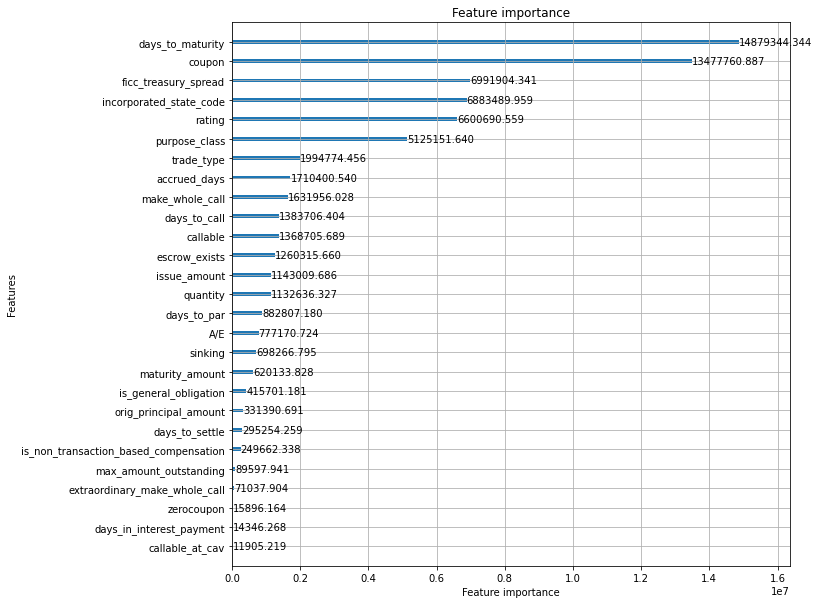

In [60]:
lightgbm.plot_importance(gbtmodel, figsize=(10,10), importance_type='gain')

In [61]:
gbtmodel.booster_.save_model('new_issue_model.txt')

# Neural Network Implementation

#### Adapting Normalization layers to the non categorical features

In [43]:
# Normalization layer for the non-categorical and binary features
noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
noncat_binary_normalizer.adapt(x_train[0], batch_size = BATCH_SIZE)

#### Setting the seed for intialization of the layers

In [44]:
tf.keras.utils.set_random_seed(10)

#### Implementation of the model

In [45]:
inputs = []
layer = []

############## INPUT BLOCK ###################
inputs.append(layers.Input(name="NON_CAT_AND_BINARY_FEATURES",
                           shape=(len(NON_CAT_FEATURES + BINARY))))


layer.append(noncat_binary_normalizer(inputs[0]))
####################################################


############## REFERENCE DATA MODEL ################
global encoders
for f in CATEGORICAL_FEATURES:
    fin = layers.Input(shape=(1,), name = f)
    inputs.append(fin)
    embedded = layers.Flatten(name = f + "_flat")(layers.Embedding(input_dim = fmax[f]+1,
                                                                   output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                   input_length= 1,
                                                                   name = f + "_embed")(fin))
    layer.append(embedded)

    
reference_hidden = layers.Dense(400,
                                activation='relu',
                                name='reference_hidden_1')(layers.concatenate(layer, axis=-1))

reference_hidden = layers.BatchNormalization()(reference_hidden)
reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

reference_hidden2 = layers.Dense(200,activation='relu',name='reference_hidden_2')(reference_hidden)
reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

reference_output = layers.Dense(100,activation='relu',name='reference_hidden_3')(reference_hidden2)

final = layers.Dense(1)(reference_output)
#################################################

model = keras.Model(inputs=inputs, outputs=final)

In [46]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rating (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 incorporated_state_code (Input  [(None, 1)]         0           []                               
 Layer)                                                                                           
                                                                                                  
 trade_type (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 purpose_class (InputLayer)     [(None, 1)]          0           []                           

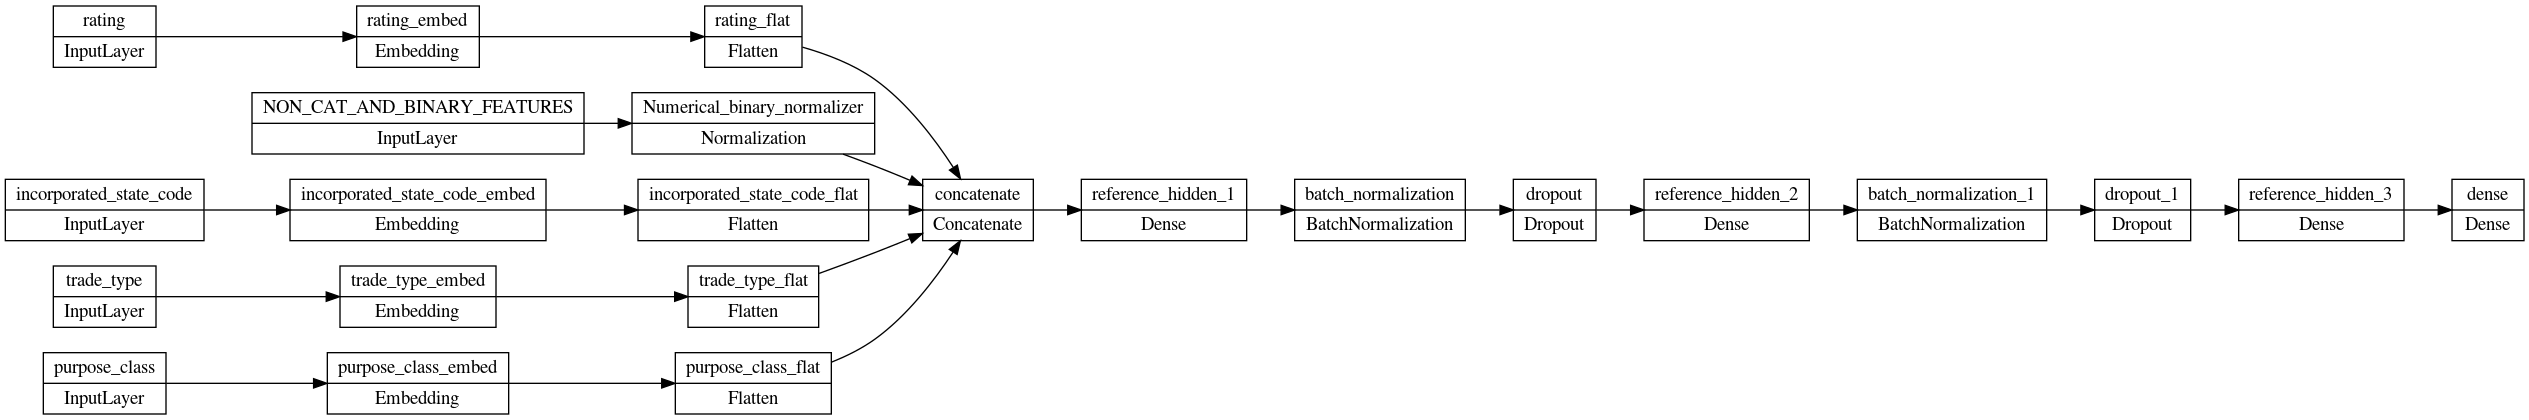

In [47]:
tf.keras.utils.plot_model(
    model,
    show_shapes=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=96,
)

In [48]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

In [49]:
fit_callbacks = [
    #WandbCallback(save_model=False),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True,
    ),
    time_callback
]

In [50]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
          loss=keras.losses.MeanAbsoluteError())

In [51]:
%%time 
history = model.fit(x_train, 
                    y_train, 
                    epochs=100, 
                    batch_size=BATCH_SIZE, 
                    verbose=1, 
                    validation_split=0.1, 
                    callbacks=fit_callbacks,
                    use_multiprocessing=True,
                    workers=8)

Epoch 1/100
7045/7045 [==============================] - 37s 5ms/step - loss: 24.9384 - val_loss: 26.2868
Epoch 2/100
7045/7045 [==============================] - 36s 5ms/step - loss: 21.6881 - val_loss: 25.4745
Epoch 3/100
7045/7045 [==============================] - 35s 5ms/step - loss: 21.0168 - val_loss: 25.1234
Epoch 4/100
7045/7045 [==============================] - 35s 5ms/step - loss: 20.5773 - val_loss: 25.0938
Epoch 5/100
7045/7045 [==============================] - 35s 5ms/step - loss: 20.2506 - val_loss: 24.5937
Epoch 6/100
7045/7045 [==============================] - 35s 5ms/step - loss: 19.9828 - val_loss: 25.5469
Epoch 7/100
7045/7045 [==============================] - 35s 5ms/step - loss: 19.7552 - val_loss: 24.7880
Epoch 8/100
7045/7045 [==============================] - 35s 5ms/step - loss: 19.5660 - val_loss: 25.0495
Epoch 9/100
7045/7045 [==============================] - 34s 5ms/step - loss: 19.3932 - val_loss: 24.6293
Epoch 10/100
7045/7045 [======================

#### Plotting train vs validation loss

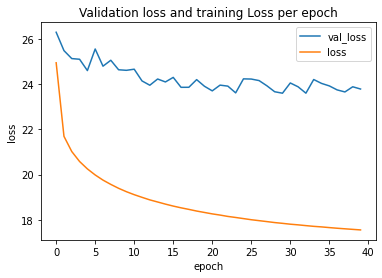

In [52]:
plt.plot(range(len(history.history['val_loss'])),history.history['val_loss'], label='val_loss')
plt.plot(range(len(history.history['loss'])),history.history['loss'], label='loss')
plt.title('Validation loss and training Loss per epoch')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Saving the model

In [53]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
file_timestamp = datetime.now().strftime('%Y-%m-%d-%H-%M')
print(f"file time stamp : {file_timestamp}")

print("Saving encoders and uploading encoders")
with open(f"encoders.pkl",'wb') as file:
    pickle.dump(encoders,file)    
upload_data(storage_client, 'ahmad_data', f"encoders.pkl")

print("Saving and uploading model")
model.save(f"saved_model_test_{file_timestamp}")
import shutil
shutil.make_archive(f"model_no_trade_history", 'zip', f"saved_model_test_{file_timestamp}")
upload_data(storage_client, 'ahmad_data', f"model_no_trade_history.zip")

#### Gigaflops for one epoch of training

In [54]:
avg_time = np.mean(time_callback.times)

In [55]:
n = len(x_train[0])
p = model.count_params()
avg_time = np.mean(time_callback.times)
gflops = ((n*p*2*3)/avg_time)/10**9

print(gflops)

225.6074095459312


### Test accuracy on the entire test set

In [56]:
test_dataframe['predicted_ys'] = model.predict(x_test, batch_size=BATCH_SIZE)
test_dataframe['predicted_ytw'] = test_dataframe['ficc_ycl'] + test_dataframe['predicted_ys']

In [57]:
test_dataframe['absolute_delta'] = np.abs(test_dataframe.yield_spread - test_dataframe.predicted_ys)

In [58]:
print(f"Test loss: {round(np.mean(np.abs(test_dataframe.yield_spread - test_dataframe.predicted_ys)), 3)}")

Test loss: 20.315


In [59]:
print(f"YTW loss: {round(np.mean(np.abs(test_dataframe['yield'] - test_dataframe.predicted_ytw)), 3)}")

YTW loss: 20.315


#### Accuracy on a daily basis for dealer dealer trades

In [60]:
for d in [d for d in pd.date_range(start="03/01/2023",end="03/31/2023",freq='D')]:
    next_day = test_dataframe[(test_dataframe.trade_date == d)].copy()
    if len(next_day) == 0:
        continue
    next_day_test = create_input(next_day)  
    next_day_preds = model.predict(next_day_test, batch_size=BATCH_SIZE)
    error = next_day.yield_spread - next_day_preds.reshape(-1)
    MAE = np.mean(np.abs(error))
    print(f"Date :{d.date()} MAE:{MAE}" )

Date :2023-03-01 MAE:20.581049054110036
Date :2023-03-02 MAE:20.63625536103541
Date :2023-03-03 MAE:19.955924278203558
Date :2023-03-06 MAE:20.29357742636101
Date :2023-03-07 MAE:19.41049638858877
Date :2023-03-08 MAE:20.101392399109844
Date :2023-03-09 MAE:18.914014573915228
Date :2023-03-10 MAE:18.778403605298937
Date :2023-03-13 MAE:21.161469244119797
Date :2023-03-14 MAE:19.725318762955965
Date :2023-03-15 MAE:20.863771614624753
Date :2023-03-16 MAE:19.621148896565597
Date :2023-03-17 MAE:20.397860699336036
Date :2023-03-20 MAE:20.019263786924565
Date :2023-03-21 MAE:19.93085627726467
Date :2023-03-22 MAE:21.153555672037214
Date :2023-03-23 MAE:21.234967765587065
Date :2023-03-24 MAE:21.871923605240003
Date :2023-03-27 MAE:20.535696252934144
Date :2023-03-28 MAE:20.48933021647137
Date :2023-03-29 MAE:21.038713573064708
Date :2023-03-30 MAE:20.572090159144867


### Test accuracy on large dealer-dealer trades
We define large as any trade which is above $500,000

In [61]:
true_mid = test_dataframe[(test_dataframe.trade_type == 'D') & (test_dataframe.quantity >= np.log10(500000))]#& (test_dataframe.coupon == 5)]

In [62]:
len(true_mid)

10705

In [63]:
%%time
x_true_mid = create_input(true_mid)
y_true_mid = true_mid.yield_spread

CPU times: user 27.3 ms, sys: 112 µs, total: 27.4 ms
Wall time: 26.8 ms


In [64]:
%%time
mae = model.evaluate(x_true_mid, y_true_mid, verbose=1, batch_size = BATCH_SIZE)
print(f"Test MAE: {round(mae, 3)}")
# wandb.log({"Dealer Dealer true mid Test MAE": mae})

11/11 [==============================] - 0s 2ms/step - loss: 20.8786
Test MAE: 20.879
CPU times: user 75.2 ms, sys: 29.3 ms, total: 104 ms
Wall time: 80.9 ms


### Plotting new ys vs predicted ys

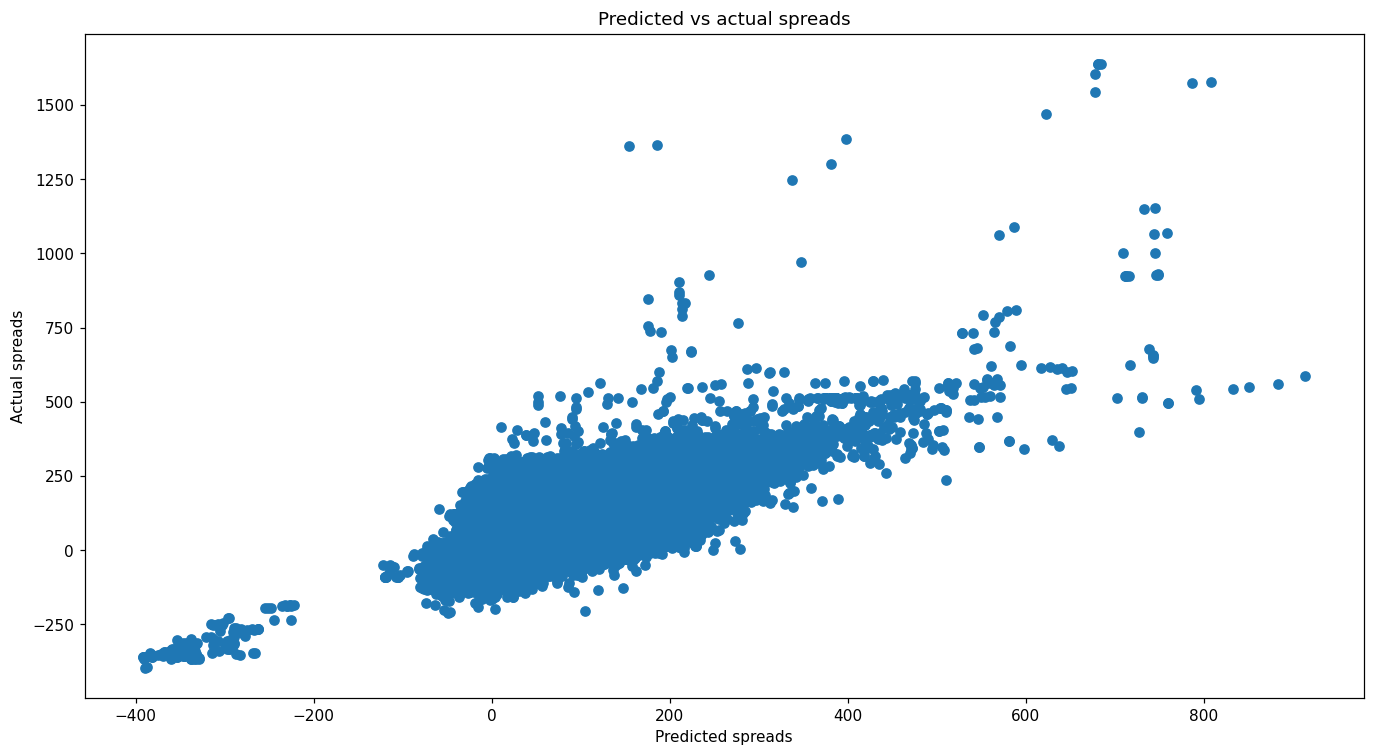

In [65]:
plt.figure(figsize=(15, 8), dpi=110)
plt.xlabel('Predicted spreads')
plt.ylabel('Actual spreads')
plt.title('Predicted vs actual spreads')
plt.scatter(test_dataframe.predicted_ys, test_dataframe.yield_spread)